In [1]:
%matplotlib inline

import jax.numpy as jnp
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as snb


from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


In [2]:
def generate_samples(key, m, K, num_samples, jitter=0):
    """ returns M samples from an Gaussian process with mean m and kernel matrix K. The function generates num_samples of z ~ N(0, I) and transforms them into f  ~ N(m, K) via the Cholesky factorization.

    
    arguments:
        key              -- jax random key for controlling the random number generator
        m                -- mean vector (shape (N,))
        K                -- kernel matrix (shape NxN)
        num_samples      -- number of samples to generate (positive integer)
        jitter           -- amount of jitter (non-negative scalar)
    
    returns 
        f_samples        -- a numpy matrix containing the samples of f (shape N x num_samples)
    """

    # generate samples from N(0, 1) of shape (N, num_samples)
    zs = random.normal(key, shape=(len(K), num_samples))

    ##############################################
    # Your solution goes here
    ##############################################
    
    N = len(K)
    L = jnp.linalg.cholesky(K + jitter*jnp.identity(N))
    f_samples = m[:, None] + jnp.dot(L, zs)
    
    ##############################################
    # End of solution
    ##############################################

    # sanity check of dimensions
    assert f_samples.shape == (len(K), num_samples), f"The shape of f_samples appears wrong. Expected shape ({len(K)}, {num_samples}), but the actual shape was {f_samples.shape}. Please check your code. "
    return f_samples


# sanity check of implementation
key = random.PRNGKey(1)
num_samples = 100000
m = jnp.array([jnp.pi, jnp.sqrt(2)])
V = jnp.array([[0.123, -0.05], [-0.05, 0.123]])
f_samples = generate_samples(key, m, V, num_samples)
assert jnp.linalg.norm(jnp.mean(f_samples, 1)- m) < 1e-2, "The mean of f_samples appears wrong. Please check your code"
assert jnp.linalg.norm(jnp.cov(f_samples) - V) < 1e-2, "The covariance of f_samples appears wrong. Please check your code"

In [3]:
def k7(X1, X2, kappa0, kappa1, kappa2, lengthscale):
    # Constant term
    constant = kappa0**2
    
    # Linear term (outer product of X1 and X2)
    linear = kappa1**2 * jnp.outer(X1.flatten(), X2.flatten())
    
    # RBF term
    # Compute pairwise squared distances
    X1_expanded = jnp.expand_dims(X1, 1)  # Shape: (N, 1, D)
    X2_expanded = jnp.expand_dims(X2, 0)  # Shape: (1, M, D)
    squared_distances = jnp.sum((X1_expanded - X2_expanded)**2, axis=2)  # Shape: (N, M)
    
    rbf = kappa2**2 * jnp.exp(-0.5 * squared_distances / (lengthscale**2))
    
    # Combine all terms
    return constant + linear.reshape(X1.shape[0], X2.shape[0]) + rbf

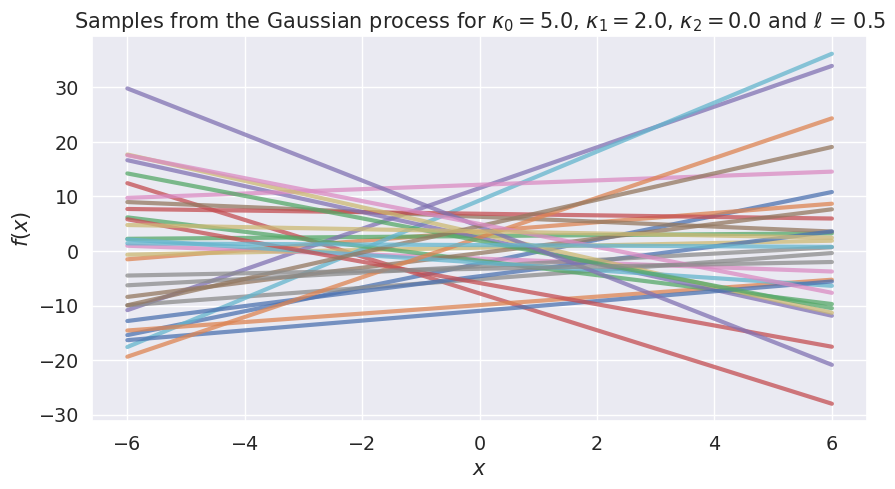

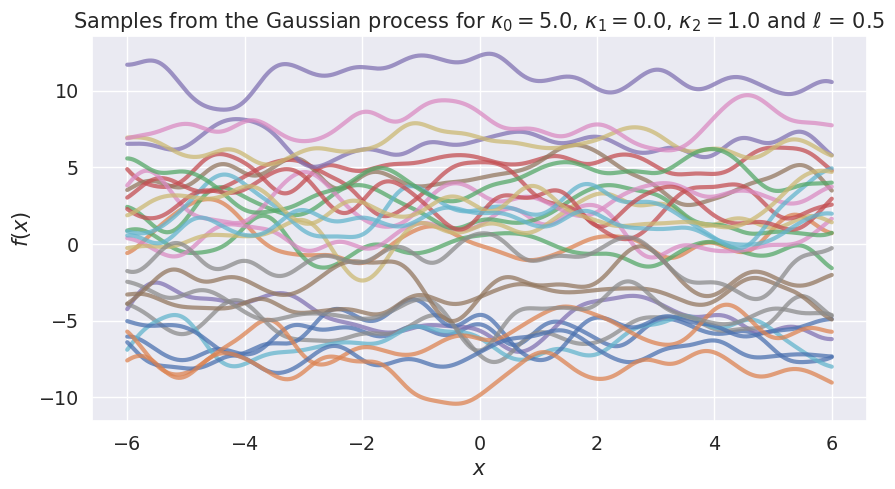

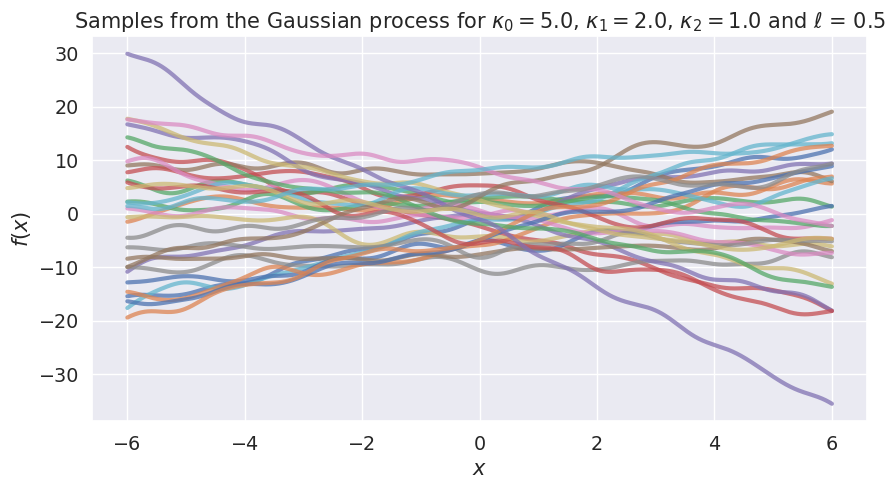

In [20]:
class Kernel(object):

    def __init__(self, kernel_fun, kappa0=1., kappa1=1., kappa2=1.,lengthscale=1.0):
        """
            the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g. 
            squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa0 = kappa0
        self.kappa1 = kappa1
        self.kappa2 = kappa2
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa0=None,  kappa1=None, kappa2=None, lengthscale=None, jitter=1e-8):
        """ compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun
    
        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar
        
        returns
            K               -- NxM matrix    
        """

        # extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa0 = self.kappa0 if kappa0 is None else kappa0
        kappa1 = self.kappa1 if kappa1 is None else kappa1
        kappa2 = self.kappa2 if kappa2 is None else kappa2
        lengthscale = self.lengthscale if lengthscale is None else lengthscale
        
        # squared exponential covariance function
        K = self.kernel_fun(X1, X2, kappa0, kappa1, kappa2, lengthscale)
        
        # add jitter to diagonal for numerical stability
        if len(X1) == len(X2) and jnp.allclose(X1, X2):
            K = K + jitter*jnp.identity(len(X1))
        
        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K

        
# create an Nx1 vector of equidistant points in [-6, 6]
N = 1000
X = jnp.linspace(-6, 6, N)[:, None]

# hyperparameters
hyperparameters = [
    (5, 2, 0, 0.5),
    (5, 0, 1, 0.5),
    (5, 2, 1, 0.5)
]

# number of samples to be plotted
num_samples = 30

# specify random seed
seed = 1
key = random.PRNGKey(1)

for kappa0, kappa1, kappa2, scale in hyperparameters:
    # instantiate kernel object and construct kernel
    kernel = Kernel(k7, kappa0, kappa1, kappa2, scale)
    K = kernel.contruct_kernel(X, X)

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    m = jnp.zeros(len(X))

    # im = ax[0].pcolormesh(X.flatten(), X.flatten(), K, shading='auto')
    # ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title=f"Kernel function $k(x, x')$ for $\\kappa0 = {kappa0:2.1f}$, $\\kappa1 = {kappa1:2.1f}$, $\\kappa2 = {kappa2:2.1f}$ and $\\ell$ = {scale:2.1f}")
    # ax[0].grid(False)
    # ax[0].set_aspect('equal')
    # add_colorbar(im, fig, ax[0])

    # eigvals = jnp.linalg.eigh(K)[0]
    # print("Min eigenvalue:", eigvals.min())  # Should be > 0

    f_samples = generate_samples(key, m, K, num_samples=num_samples, jitter=1e-8)
    ax.plot(X, f_samples, alpha=0.75, linewidth=3);
    ax.grid(True)
    ax.set(xlabel='$x$', ylabel='$f(x)$', title=f'Samples from the Gaussian process for $\\kappa_0 = {kappa0:2.1f}$, $\\kappa_1 = {kappa1:2.1f}$, $\\kappa_2 = {kappa2:2.1f}$ and $\\ell$ = {scale:2.1f}');